In [1]:
import sys
sys.path.append('..')

from src.tp import TP
from src.gp import ExactGP

import gpax
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import plotly.graph_objects as go

# Set the random seed and parameters
np.random.seed(0)
NUM_INIT_POINTS = 40
NOISE_LEVEL = 0.1
OUTLIER_NUM = 10

# Define the known function and generate data
f = lambda x: np.sin(10 * x)
X = np.random.uniform(-1., 1., NUM_INIT_POINTS)
y = f(X) + np.random.normal(0., NOISE_LEVEL, NUM_INIT_POINTS)
outlier_idx = np.random.choice(NUM_INIT_POINTS, 10)
for idx in outlier_idx:
    outlier_weight = 1 + np.random.rand(1)
    if idx % 2 == 0:
        y[idx] += outlier_weight
    else:
        y[idx] -= outlier_weight

# Create the plot with Plotly
fig = go.Figure()

# Add noisy data points
fig.add_trace(go.Scatter(x=X, y=y, mode='markers', name='Noisy Data',
                         marker=dict(size=8, color='blue')))

# Plot the true function without noise
X_line = np.linspace(-1, 1, 500)
y_line = f(X_line)
fig.add_trace(go.Scatter(x=X_line, y=y_line, mode='lines', name='True Function',
                         line=dict(color='red')))

# Update the layout
fig.update_layout(
    title='Noisy Data with Outlier and True Function',
    xaxis_title='x',
    yaxis_title='y',
    showlegend=True
)

# Show the plot
fig.show()


/var/folders/_b/b62kq0490fn2ptq7m4mbp8yr0000gp/T/ipykernel_57958/2579825121.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y[idx] -= outlier_weight
/var/folders/_b/b62kq0490fn2ptq7m4mbp8yr0000gp/T/ipykernel_57958/2579825121.py:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y[idx] += outlier_weight


In [98]:
# Get random number generator keys for training and prediction
rng_key, rng_key_predict = gpax.utils.get_keys()

# Initialize model
model = TP(1, kernel='Matern')
# Run Hamiltonian Monte Carlo to obtain posterior samples for kernel parameters and model noise
model.fit(rng_key, X, y, num_chains=1)

sample: 100%|██████████| 4000/4000 [00:07<00:00, 548.96it/s, 15 steps of size 1.19e-01. acc. prob=0.95]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
         df     10.13      9.48      7.21      0.09     22.81    731.75      1.00
k_length[0]      0.66      1.36      0.21      0.03      1.79    546.17      1.00
    k_scale      0.87      0.81      0.63      0.05      1.74   1112.39      1.00
      noise      1.31      0.95      1.09      0.27      2.26    736.90      1.00
          r      0.20      0.39      0.10      0.01      0.41    711.03      1.00



In [99]:
X_test = np.linspace(-1, 1, 100)
y_pred, y_sampled = model.predict(rng_key_predict, X_test, n=200)

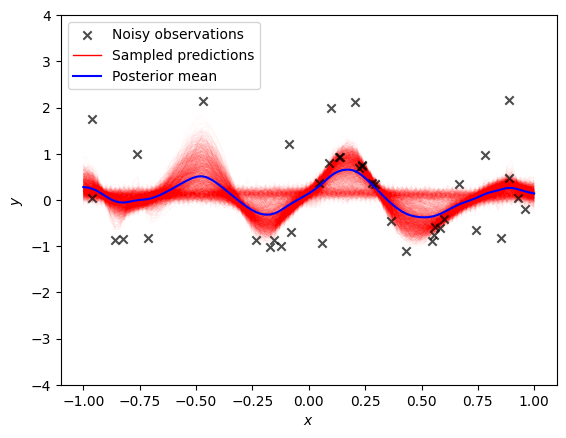

In [100]:
_, ax = plt.subplots(dpi=100)
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")
ax.scatter(X, y, marker='x', c='k', zorder=1, label="Noisy observations", alpha=0.7)
for y1 in y_sampled:
    ax.plot(X_test, y1.mean(0), lw=.1, zorder=0, c='r', alpha=.1)
l, = ax.plot(X_test, y_sampled[0].mean(0), lw=1, c='r', alpha=1, label="Sampled predictions")
ax.plot(X_test, y_pred, lw=1.5, zorder=1, c='b', label='Posterior mean')
ax.legend(loc='upper left')
l.set_alpha(0)
ax.set_ylim(-4, 4);

In [101]:
y_pred_tp = y_pred

sample: 100%|██████████| 4000/4000 [00:02<00:00, 1423.80it/s, 3 steps of size 4.05e-01. acc. prob=0.91] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      0.73      1.63      0.21      0.02      2.02    601.96      1.00
    k_scale      0.70      0.63      0.53      0.06      1.40    791.46      1.00
      noise      0.84      0.27      0.80      0.45      1.25    603.00      1.00



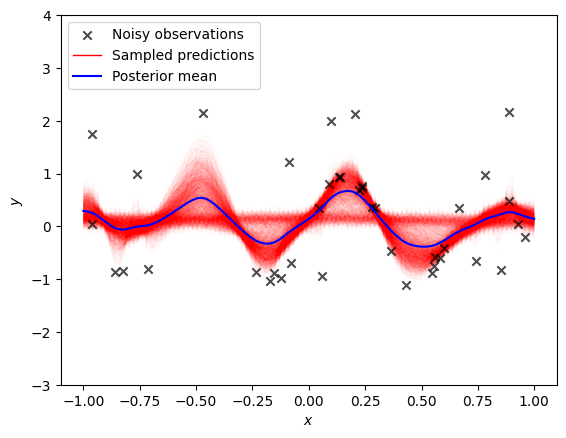

In [102]:
# Get random number generator keys for training and prediction
rng_key, rng_key_predict = gpax.utils.get_keys()

# Initialize model
model = ExactGP(1, kernel='Matern')
# Run Hamiltonian Monte Carlo to obtain posterior samples for kernel parameters and model noise
model.fit(rng_key, X, y, num_chains=1)

X_test = np.linspace(-1, 1, 100)
y_pred, y_sampled = model.predict(rng_key_predict, X_test, n=200)

_, ax = plt.subplots(dpi=100)
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")
ax.scatter(X, y, marker='x', c='k', zorder=1, label="Noisy observations", alpha=0.7)
for y1 in y_sampled:
    ax.plot(X_test, y1.mean(0), lw=.1, zorder=0, c='r', alpha=.1)
l, = ax.plot(X_test, y_sampled[0].mean(0), lw=1, c='r', alpha=1, label="Sampled predictions")
ax.plot(X_test, y_pred, lw=1.5, zorder=1, c='b', label='Posterior mean')
ax.legend(loc='upper left')
l.set_alpha(0)
ax.set_ylim(-3, 4);

In [103]:
y_pred_gp = y_pred

In [104]:
sum(abs(y_pred_tp - y_pred_gp))

Array(0.7652277, dtype=float32)

In [106]:
model.kernel

<PjitFunction of <function MaternKernel at 0x118109260>>

In [ ]:
y_centered = y_sampled - y_pred 
cov = (1 / (len(y_sampled) - 1)) * (y_centered)

In [110]:
y_sampled.T.shape

(100, 200, 2000)

In [111]:
y_sampled.T @ y_sampled

ValueError: Incompatible shapes for matmul arguments: (100, 200, 2000) and (2000, 200, 100)

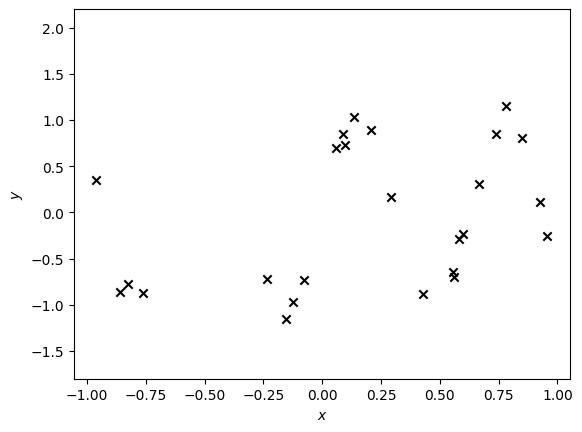

In [35]:
np.random.seed(0)

NUM_INIT_POINTS = 25 # number of observation points
NOISE_LEVEL = 0.1 # noise level

# Generate noisy data from a known function
f = lambda x: np.sin(10*x)

X = np.random.uniform(-1., 1., NUM_INIT_POINTS)
y = f(X) + np.random.normal(0., NOISE_LEVEL, NUM_INIT_POINTS)

# Plot generated data
plt.figure(dpi=100)
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.scatter(X, y, marker='x', c='k', zorder=1, label='Noisy observations')
plt.ylim(-1.8, 2.2);

In [36]:
# Get random number generator keys for training and prediction
rng_key, rng_key_predict = gpax.utils.get_keys()

# Initialize model
model = TP(1, kernel='RBF')
# Run Hamiltonian Monte Carlo to obtain posterior samples for kernel parameters and model noise
model.fit(rng_key, X, y, num_chains=1)

sample: 100%|██████████| 4000/4000 [00:03<00:00, 1040.10it/s, 15 steps of size 1.53e-01. acc. prob=0.94]


                 mean       std    median      5.0%     95.0%     n_eff     r_hat
         df      3.70      5.47      1.55      0.02     10.04    793.39      1.00
k_length[0]      0.15      0.03      0.15      0.10      0.20   1005.08      1.00
    k_scale      4.02      4.28      2.72      0.40      8.38    959.37      1.00
      noise      0.11      0.11      0.08      0.01      0.23    970.30      1.00
          r      0.26      0.39      0.16      0.02      0.53    892.11      1.00



In [37]:
X_test = np.linspace(-1, 1, 100)
y_pred, y_sampled = model.predict(rng_key_predict, X_test, n=200)

In [53]:
y_sampled[0].mean(0).shape

(100,)

(-1.8, 2.2)

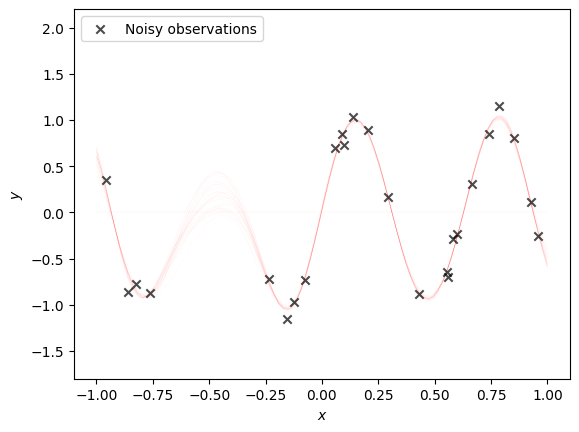

In [59]:
_, ax = plt.subplots(dpi=100)
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")
ax.scatter(X, y, marker='x', c='k', zorder=1, label="Noisy observations", alpha=0.7)
for y1 in y_sampled[:30]:
    ax.plot(X_test, y1.mean(0), lw=.1, zorder=0, c='r', alpha=.1)
# l, = ax.plot(X_test, y_sampled[0].mean(0), lw=1, c='r', label="Sampled predictions")
# ax.plot(X_test, y_pred, lw=1.5, zorder=1, c='b', label='Posterior mean')
ax.legend(loc='upper left')
ax.set_ylim(-1.8, 2.2)